# Стратегия развития фитнес-центра «Культурист-датасаентист» на основе анализа оттока клиентов и кластеризации

**Цель:** <br> 
<br>
Подготовка план действий по удержанию клиентов на основе анализа анкет клиентов. <br>
<br>
**Задачи:**
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- определить типичных портретов клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать **основные выводы и разработать рекомендации по повышению качества работы с клиентами**:
  * выделить целевые группы клиентов;
  * предложить меры по снижению оттока;
  * определить другие особенности взаимодействия с клиентами.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import itertools
import warnings
warnings.filterwarnings('ignore')

## Изучение исходных данных

In [3]:
gym = pd.read_csv('/Users/dasakalinina/Desktop/Practicum/_all_projects/GYM/gym_churn.csv')
display(gym.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Таблица состоит из 14 столбцов и 4000 строк с разными типами значений.**

**Количественные переменные:**
* gender
* Near_Location
* Partner
* Promo_Friends
* Phone
* Contract_period
* Group_visits
* Age
* Lifetime
* Churn

**Вещественные переменные:**
* Avg_additional_charges_total
* Avg_class_frequency_total
* Avg_class_frequency_current_month

In [5]:
#проверяю дубликаты
print('Общее число дубликатов:', gym.duplicated().sum())

#проверяю пропуски
print('Общее число пропущенных значений:', gym.isna().sum())

Общее число дубликатов: 0
Общее число пропущенных значений: gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


Пропусков данных и явных дубликатов не обнаружено.

## Предобработка данных

In [6]:
#переименуем ряд заголовков: сделаем написание строчными буквами
gym.columns = map(str.lower, gym.columns)
display(gym.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных (EDA)

### Первичная оценка параметров данных

In [7]:
#применим метод describe для первичной оценки параметров
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**gender:**

    - количество клиентов с полом 1 составляет 51%, в целом, можно сказать, что деление 50 на 50.

**near_location:**

    - количество клиентов,  у которых фитнес центр находится в районе проживания / работы составляет 84,5%.
    
**partner:**

    - 48,7% клиентов пришли со скидкой от компании-партнера клуба.
    
**promo_friends:**

    - 30% клиентов пришли по акции Приведи друга.  

**phone:**

    - 90% клиентов указали номер телефона. 

**contract_period:**

    - средняя длительность текущего абонемента у клиентов составляет 4.68 месяцев
    - медиана составляет - 1 месяц, а стандартное отклонение - 4,54 месяца. Таким образом, как минимум 50% клиентов приобретают абонемент всего на 1 месяц и лишь 25% клиентов на 6 месяцев и больше.

**group_visits:**

     - количество клиентов, которые посещают групповые занятия составляет 41,2%.
     
**group_visits:**

     - средний возраст клиентов фитнес-клуба - 29 лет,
     - медианный возраст также - 29 лет,
     - 25% клиентов фитнес-клуба старше 31 года, 25% младше 27 лет,
     - максимальный возраст клиентов фитнес-клуба - 41 год, минимальный - 18 лет.
     
**avg_additional_charges_total**:

    - средняя суммарная выручка от других услуг фитнес-центра составялет 146.9 у.е.
    - медианная - 136,
    - 25% из выборки расходуют 68.6% и меньше, 25% - 210.95 и больше,
    - максимальный расход - 552, минимальный - 0.14.
    
**month_to_end_contract:**

    - средний срок до оконачания текущего абонемента составляет 4.32 месяца, 
    - медиана составляет - 1 месяц, а стандартное отклонение  - 4,19 месяца. 
    Таким образом, как минимум у 50% клиентов доконца абонемента - 1 месяц и меньше и лишь у 25% клиентов до окончания абонемента 5 месяцев и больше.
    В целом цифры совпадают с аналогичными по сроку контракта.
    
**lifetime:**

    - средний "срок жизни" текущих клиентов составляет - 3.72 месяца,
    - медианный - 3 месяца,
    - 25% клиентов ходят 1 месяц и меньше, также 25% - 5 месяцев и больше,
    - максимальный "срок жизни" - 31 месяц, минимальный - 0 (пришли на 1 день/1 промо-занятие? просто оставили данные?)

**avg_class_frequency_total:**

    - средняя частота посещений в неделю за весь срок действия абонемента составляет - 1.88 шт.,
    - медианная - 1.83,
    - 25% клиентов ходили на 1.18 занятий и меньше, также 25% - 2.5 и больше,
    - максимальный количество посещаемых занятий - 6, минимальное - 0
    
**avg_class_frequency_current_month:**

    - средняя частота посещений в неделю за текущий месяц составляет - 1.77 шт.,
    - медианная - 1.72,
    - 25% клиентов ходили на 0.96 занятий и меньше, также 25% - 2.5 и больше (число не поменялось по сравнению со средним посещением),
    - максимальный количество посещаемых занятий - 6, минимальное - 0
    
**churn:**

    - отток клиентов за текущий месяц составляет 26.5%.

### Средние значения и распределение признаков в группе оставшихся клиентов и в группе ушедших

In [8]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
gym.groupby(['churn']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Те, кто остался:
* примерно одинаковые по соотношению полов, номеров телефонов с теми, кто ушел
* чаще живут/работают рядом со спортзалом
* чаще **работают в компании-партнере фитнесс-центра**
* чаще пришли **по программе Приведи друга**
* имеют **более длительный контракт** и более длительный срок до окончания контакта, а также более длинный lifetime
* чаще **посещают групповые занятия**
* более зрелые (но в среднем разница всего 3 года)
* чаще оплачивают дополнительные услуги
* чаще посещают групповые занятия (2 в неделю), те, кто уходят - меньше 1.5. 
* **посещение групповых занятий в текущем месяце у них такое же, как и в предущие**. При этом, у тех, кто уйдет, оно снизилось.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

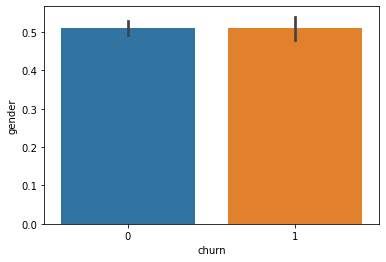

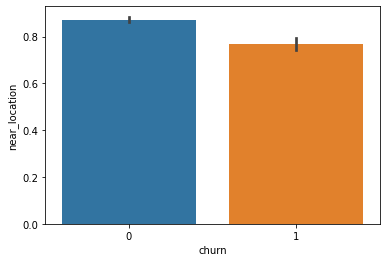

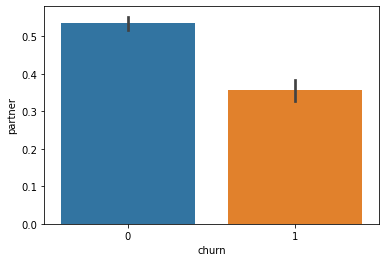

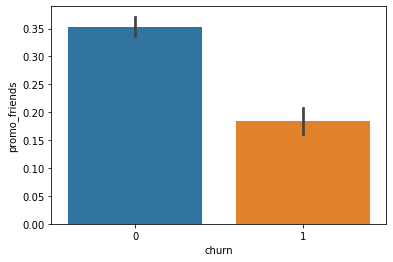

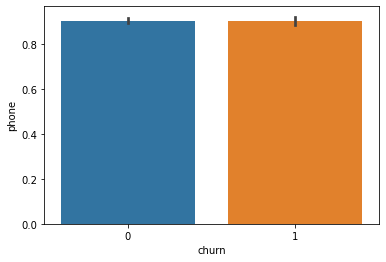

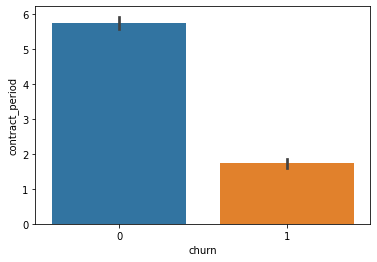

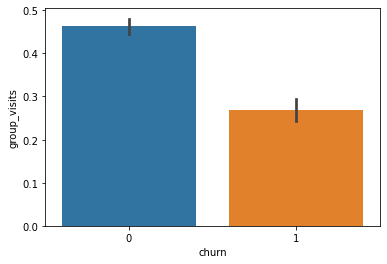

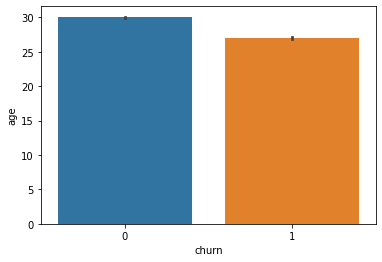

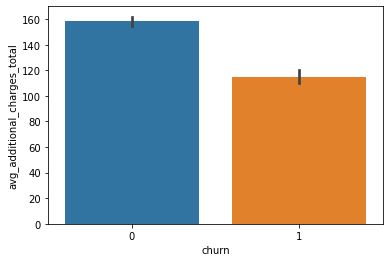

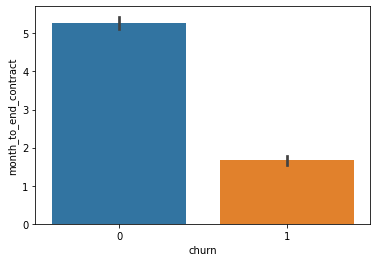

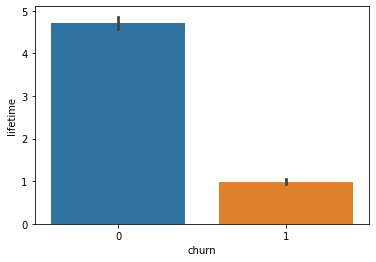

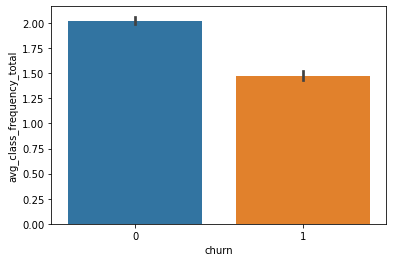

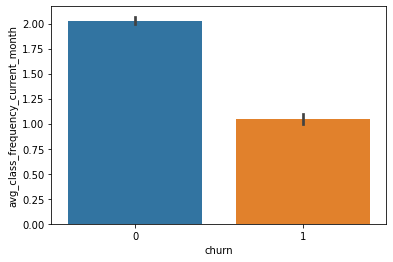

In [9]:
for col in gym.drop('churn', axis = 1).columns:
    sns.barplot(data=gym, x='churn', y=col)#ваш код здесь
    plt.show()

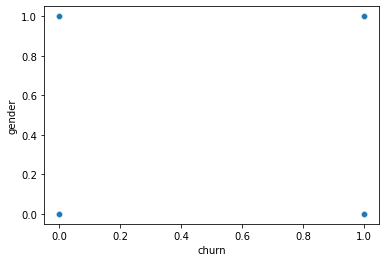

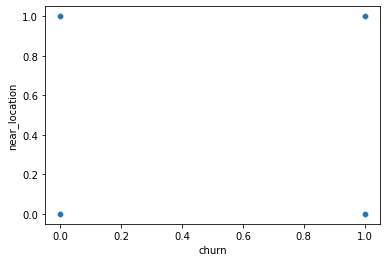

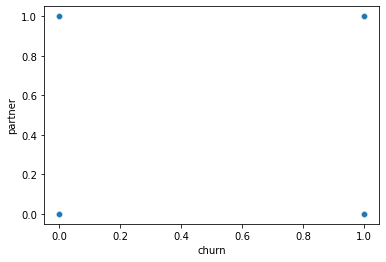

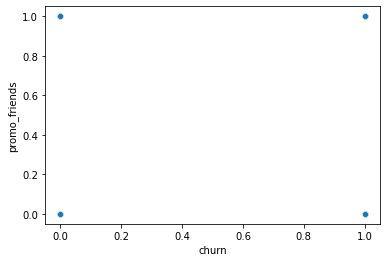

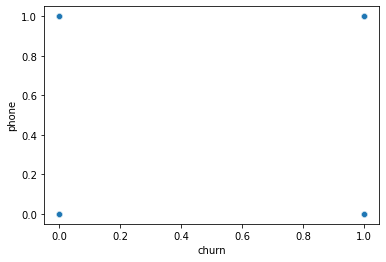

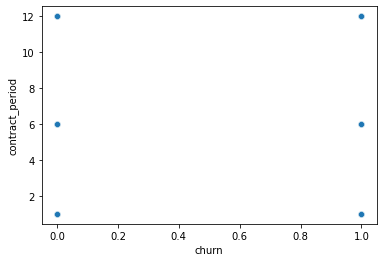

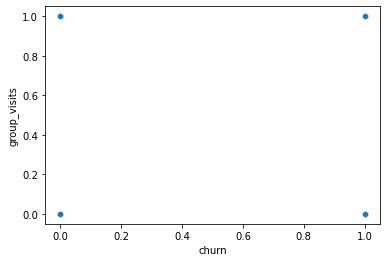

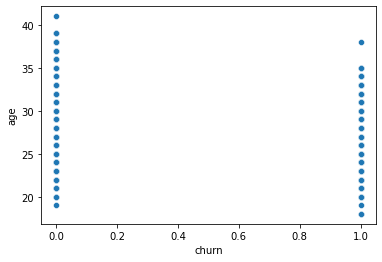

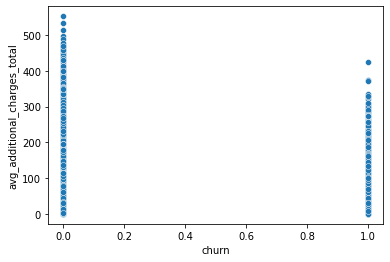

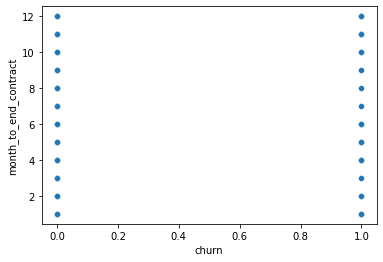

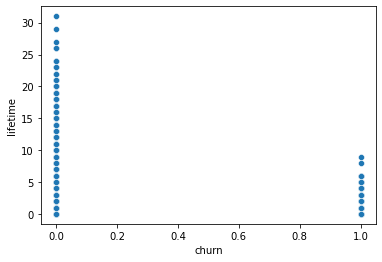

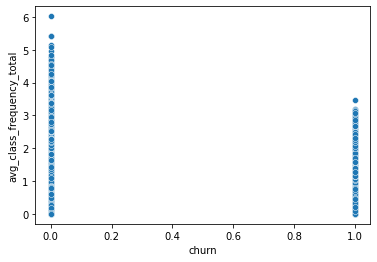

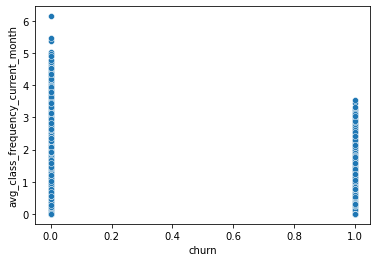

In [10]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in gym.drop('churn', axis = 1).columns:
    sns.scatterplot(data=gym, x="churn", y=col)#ваш код здесь
    plt.show()

Диаграммы рассеяния и столбчатые диаграммы подтверждают выводы, сделанные по средним значениям:
- возраст - более "зрелые" клиенты более лояльны
- дополнительные расходы в клубе - использование дополнительных услуг фитнес-клуба снижает вероятность "ухода"
- срок "жизни" клиента в клубе - чем он больше, тем выше вероятность, что клиент продолжит ходить
- посещение групповых классов - если клиент их посещает и чем чаще он их посещает, тем меньше вероятность, что он уйдет в следующем месяце

**Особенно следует отметить, что снижение среднего числа посещений групповых занятий в неделю, является "спутником" ухода клиента.**

### Матрица корреляций признаков

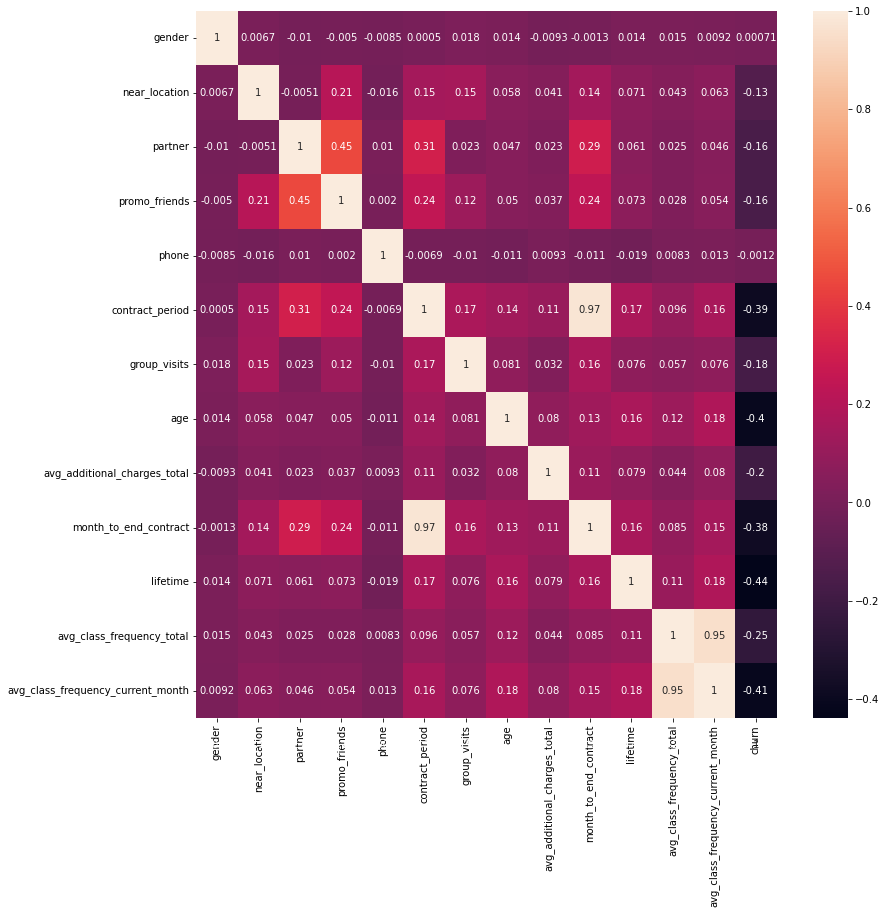

In [11]:
#построим и отрисуем матрицу корреляций
cm = gym.corr()
fig, ax = plt.subplots(figsize = (13, 13))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True)#ваш код здесь
ax.set_ylim(
   13, 0
)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

4 параметра с очень сильной корреляцией:
- contract_period и month_to_end_contract_period. Это мультиколлинеарные признаки, удалим один из столбцов и построим матрицу корреляции еще раз.
- avg_class_frequency_total и avg_class_current_month

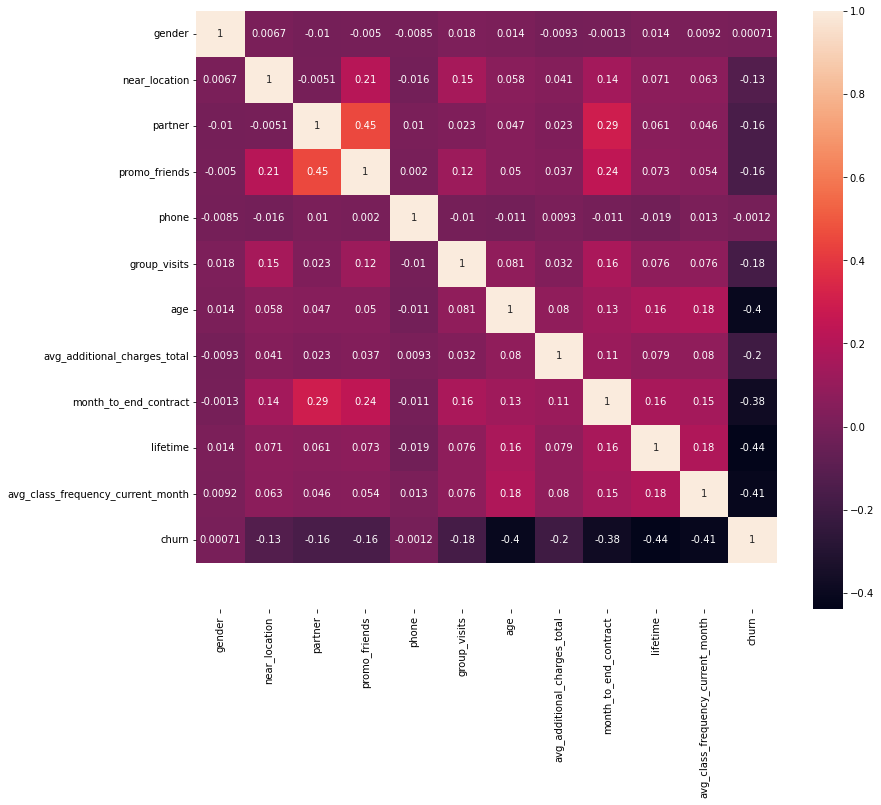

In [12]:
gym_2 = gym.drop(['avg_class_frequency_total', 'contract_period'], axis = 1)
#построим и отрисуем матрицу корреляций
cm = gym_2.corr()
fig, ax = plt.subplots(figsize = (13, 11))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True)#ваш код здесь
ax.set_ylim(
    13, 0
)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

По матрице корреляций можно отметить, что максимальное влияние на уровень оттока оказывают следующие параметры:
- возраст
- количество месяцев до окончания контракта
- lifetime клиента
- средняя частота посещения занятий

## Модель прогнозирования оттока клиентов

### Разделение признаков, их стандартизация

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis=1)
y = gym['churn']

In [14]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [15]:
# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Создание и обучение моделей, расчет метрик и сравнение моделей

In [16]:
# задаем список моделей
models = [
    LogisticRegression(random_state = 0),
    RandomForestClassifier(random_state = 0),
]

In [17]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )


# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
    m=i,
    X_train=X_train_st,
    y_train=y_train,
    X_test=X_test_st,
    y_test=y_test,
    )

LogisticRegression(random_state=0)
Accuracy: 0.92 Precision: 0.85 Recall: 0.83
RandomForestClassifier(random_state=0)
Accuracy: 0.92 Precision: 0.84 Recall: 0.81


По признаку Accuracy модель идентичны, но по признакам Precision и Recall, получается, что более точная модель Logistic Regression.

## Кластеризация клиентов

In [18]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym)

### Кластеризация с использованием дендрограммы

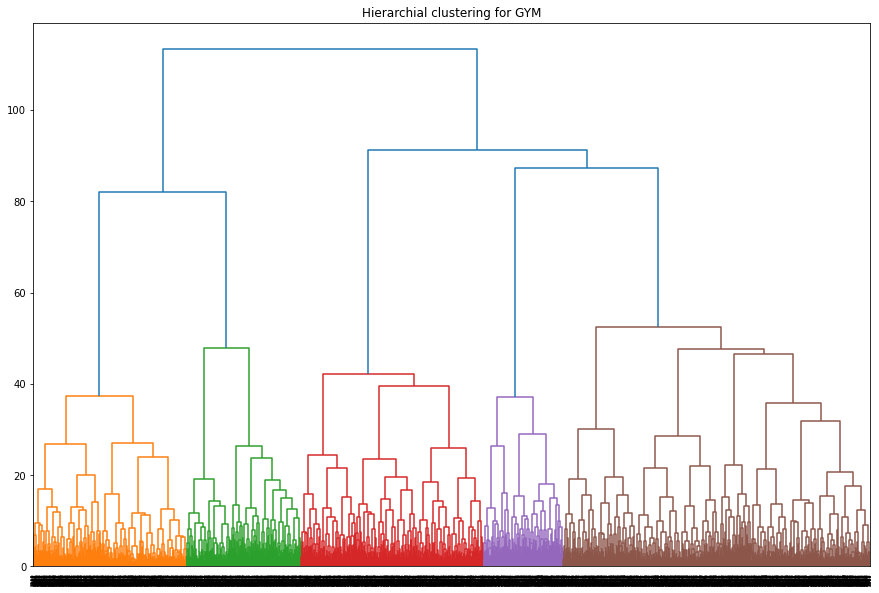

In [19]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

И использованием дендрограммы мы можем выделить 5 разных классов клиентов. Проведем кластеризацию методом K-means и оценим их основные признаки.

### Кластеризация методом K-means

In [20]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [21]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(gym.groupby('cluster').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


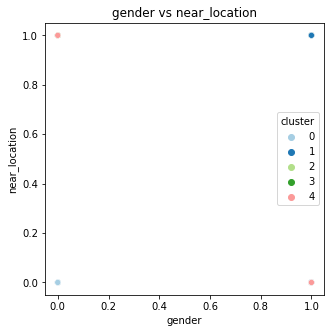

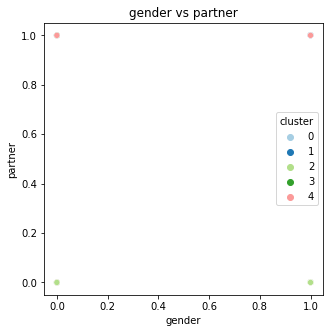

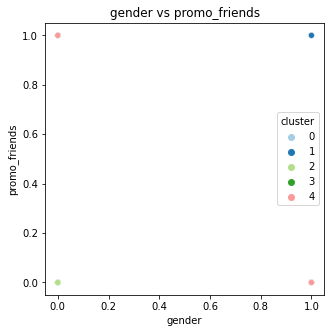

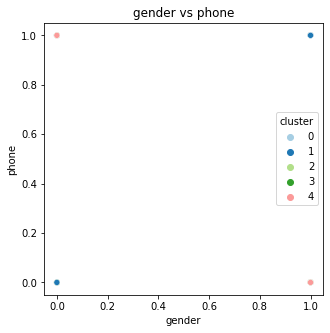

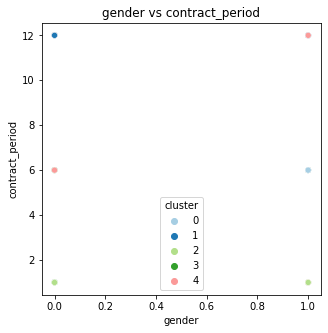

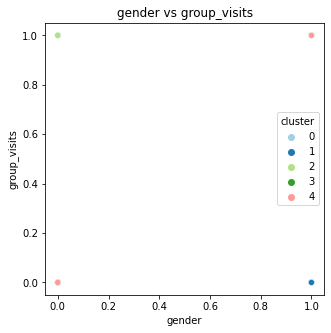

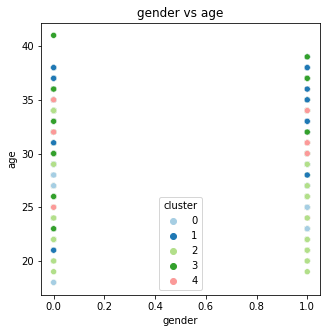

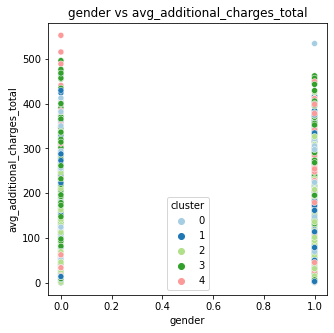

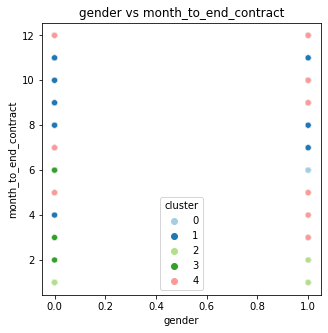

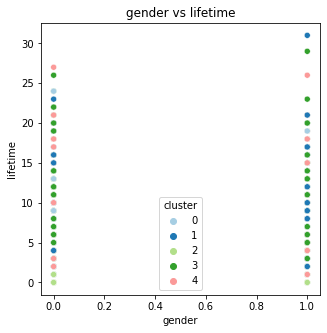

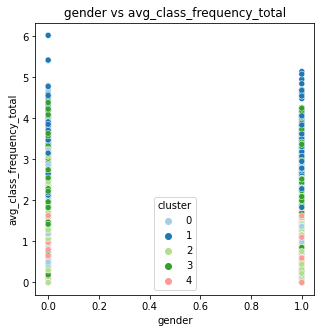

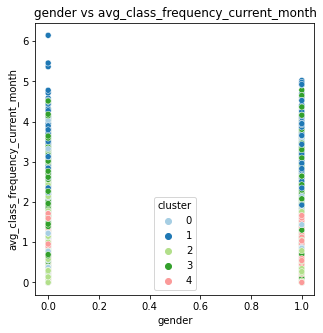

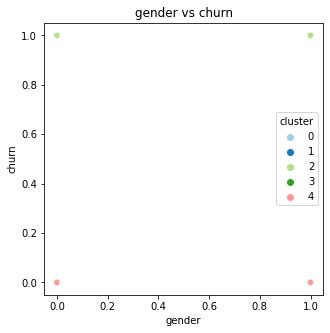

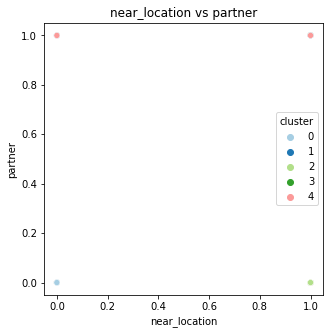

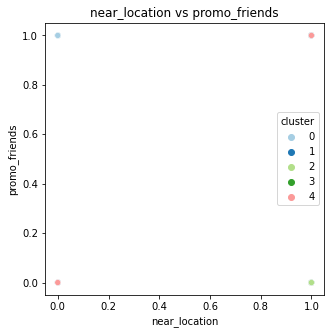

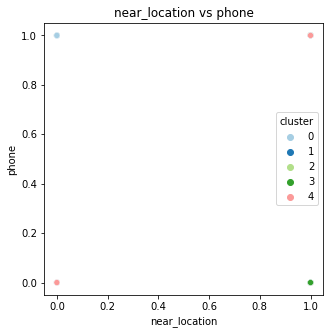

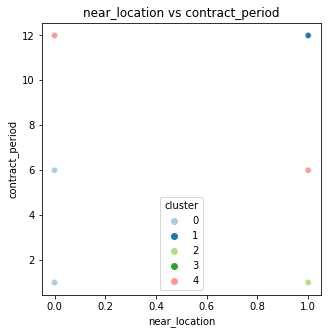

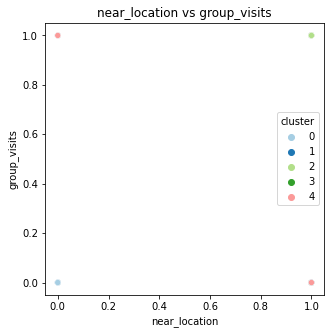

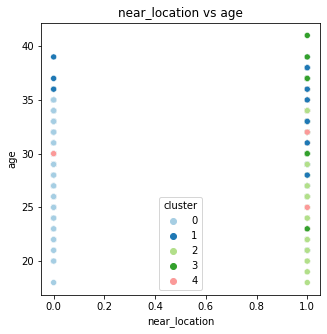

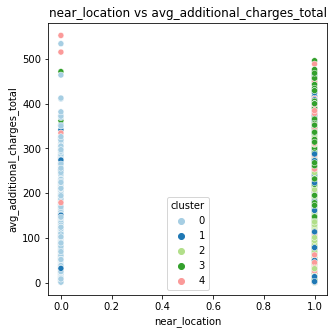

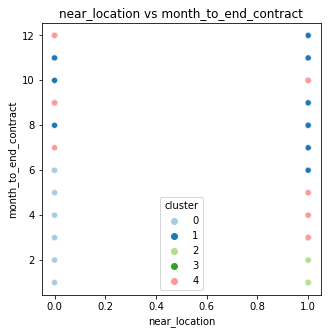

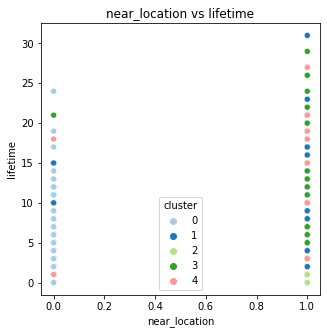

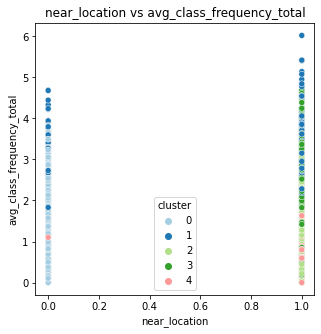

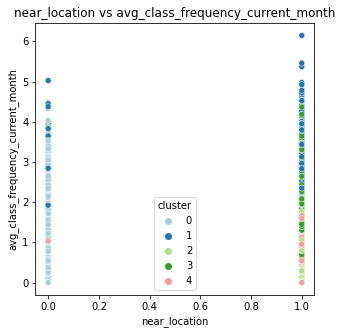

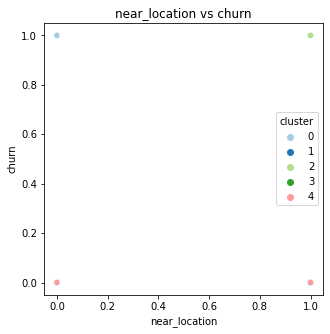

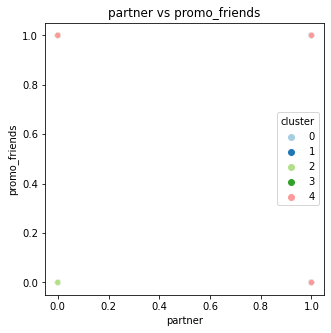

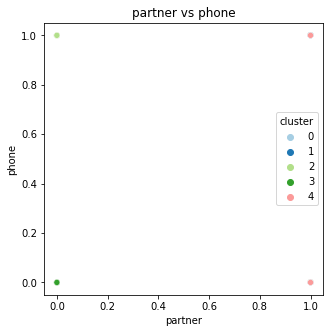

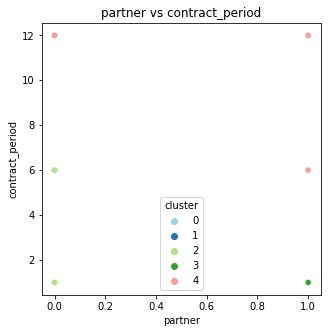

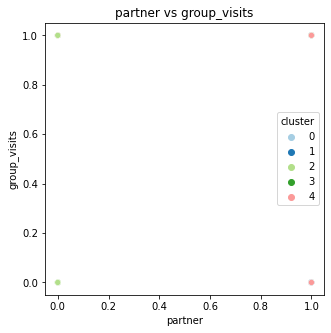

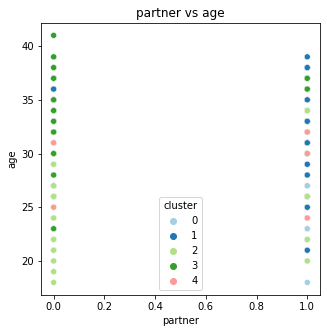

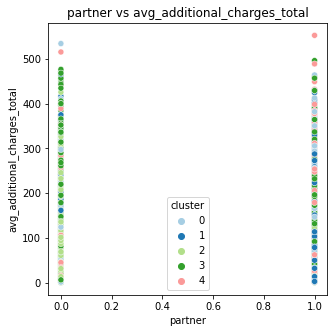

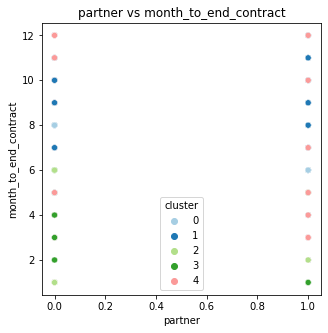

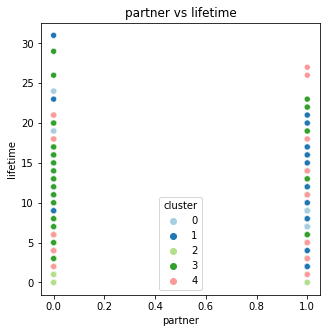

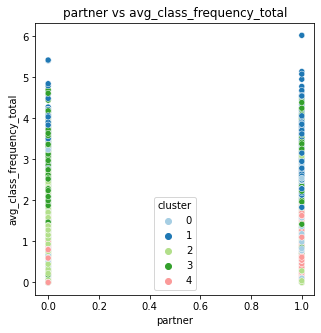

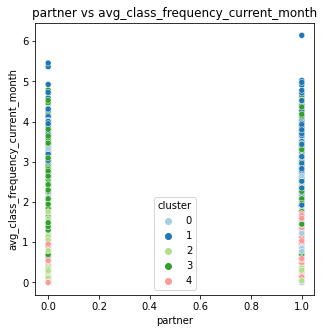

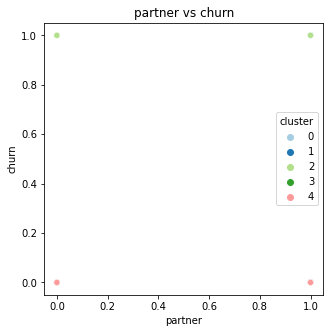

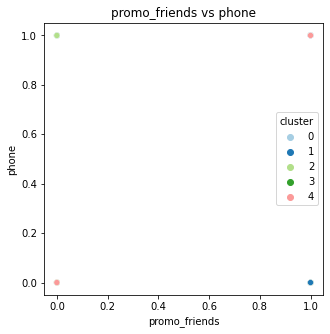

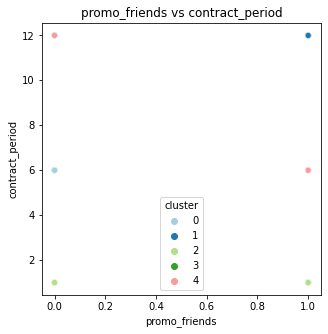

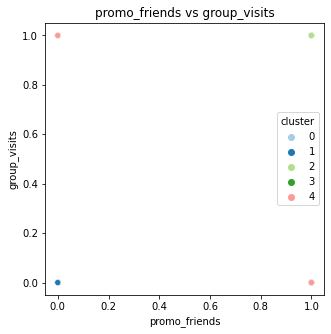

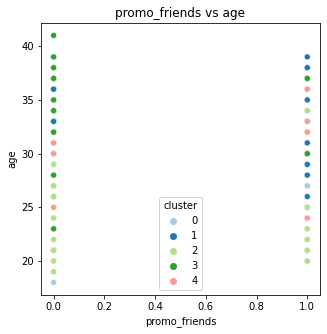

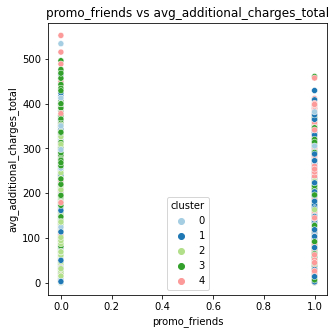

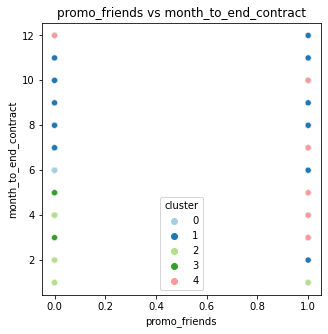

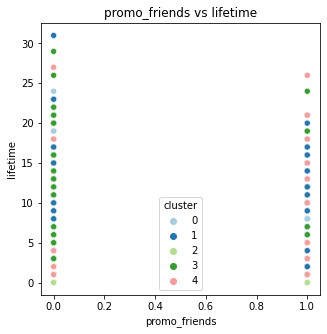

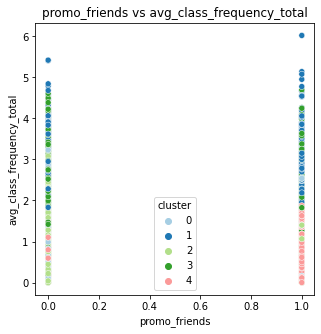

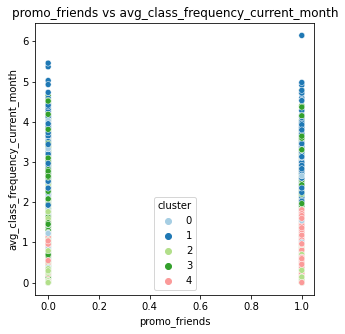

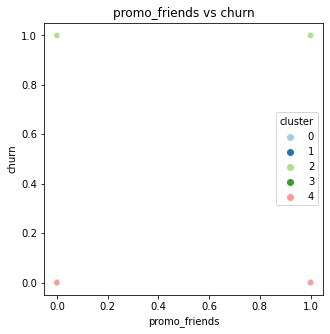

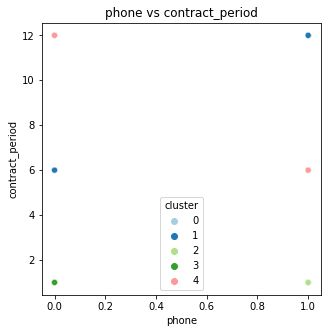

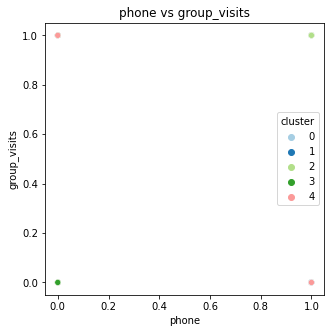

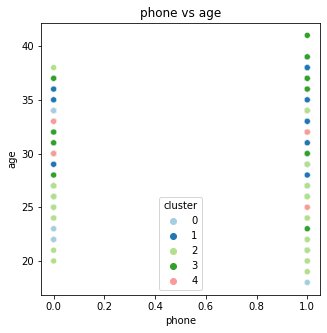

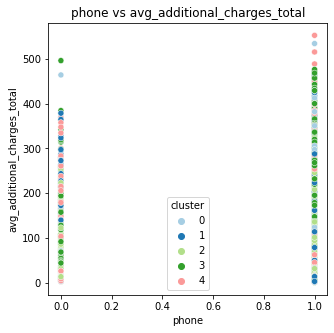

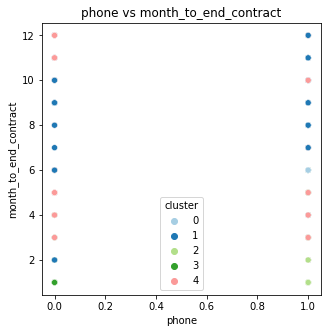

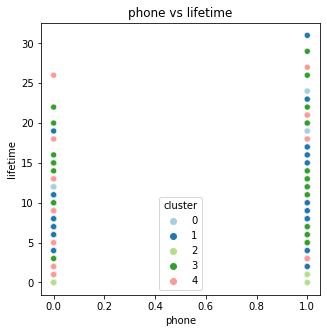

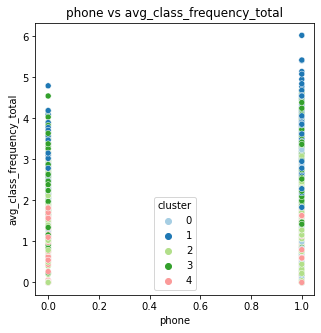

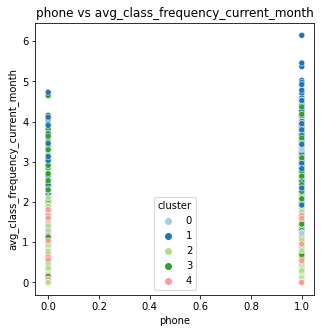

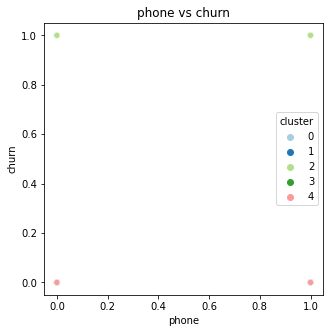

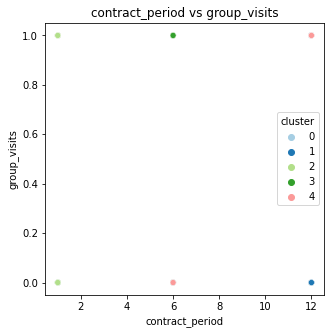

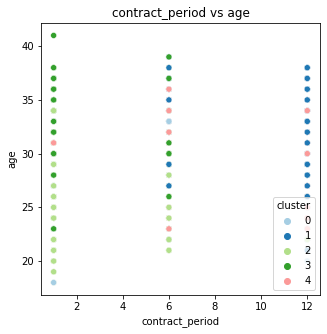

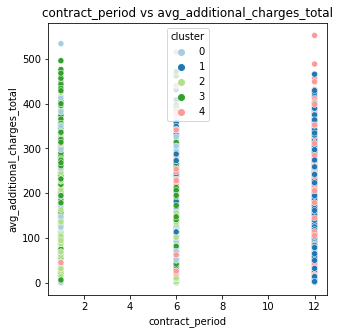

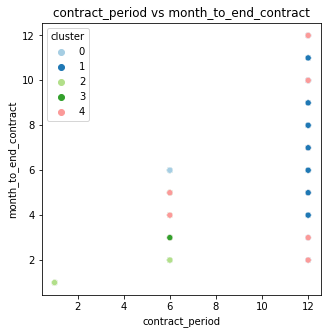

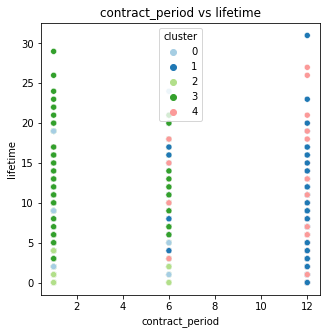

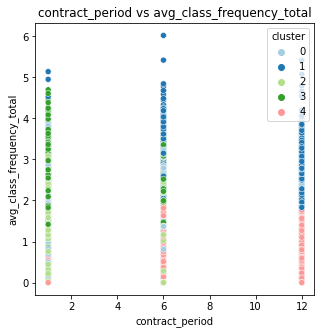

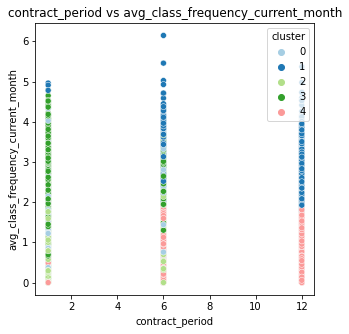

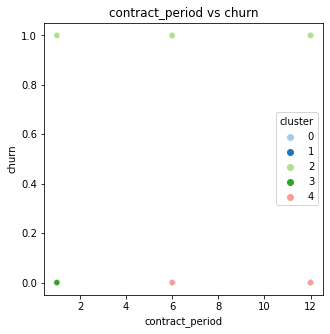

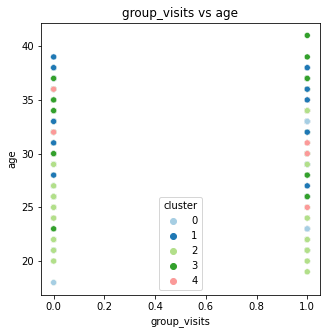

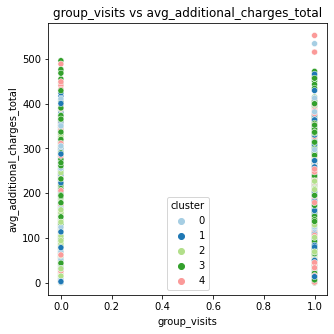

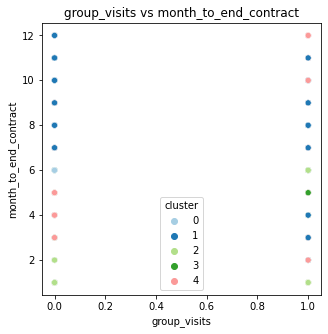

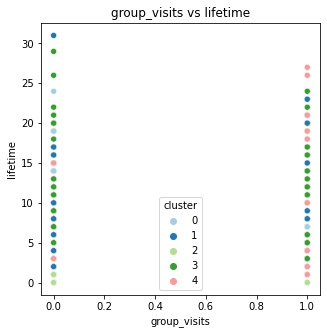

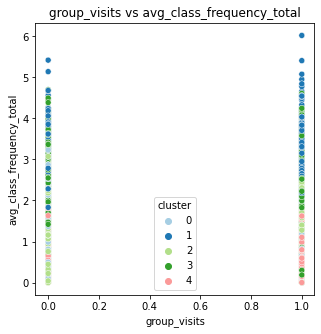

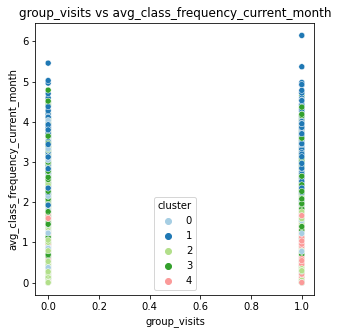

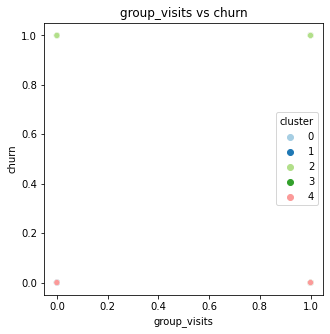

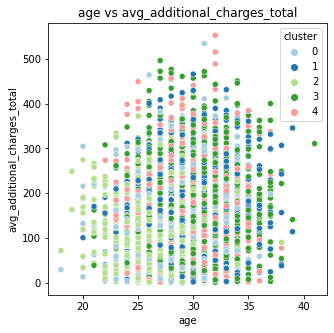

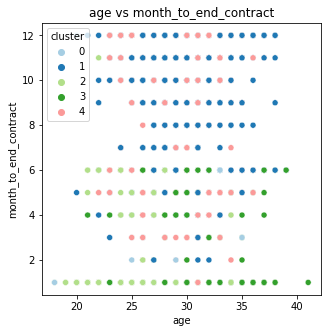

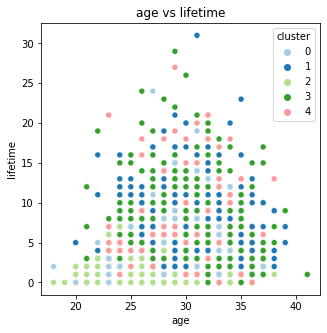

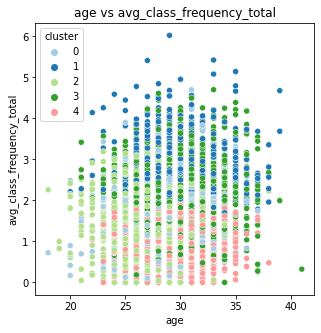

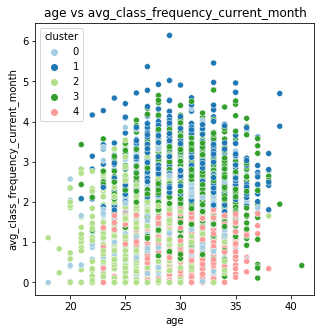

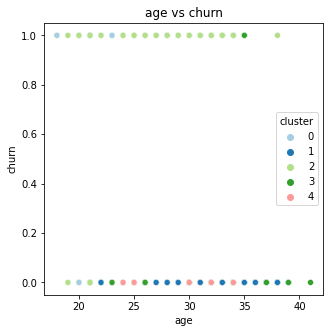

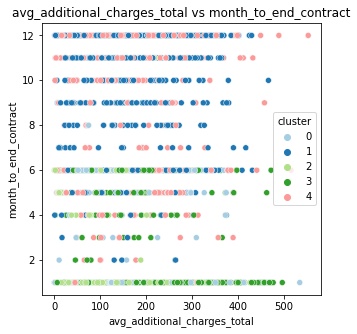

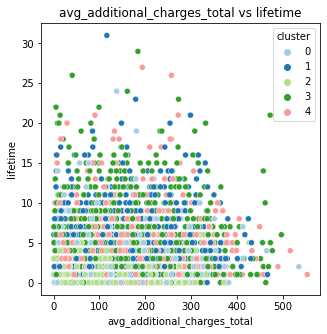

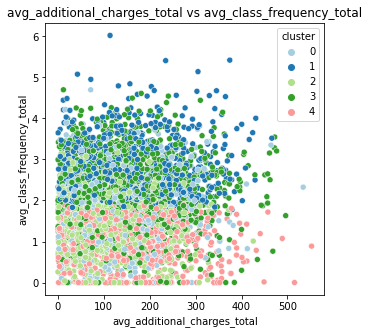

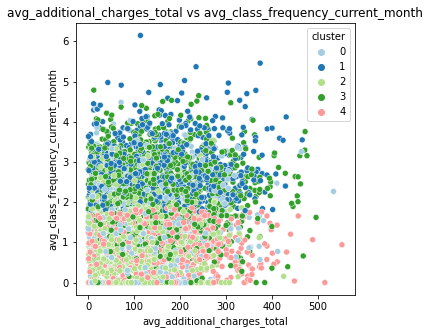

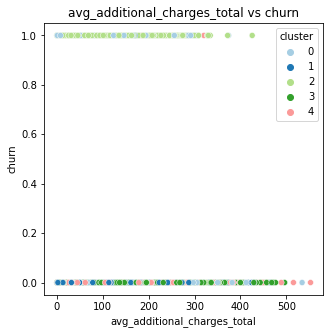

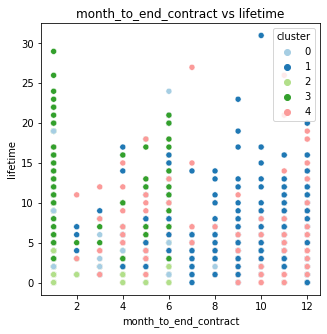

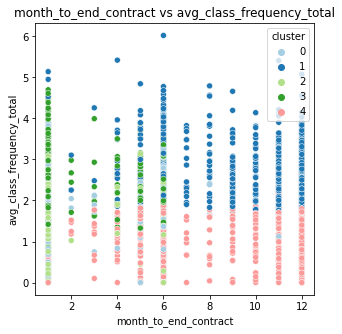

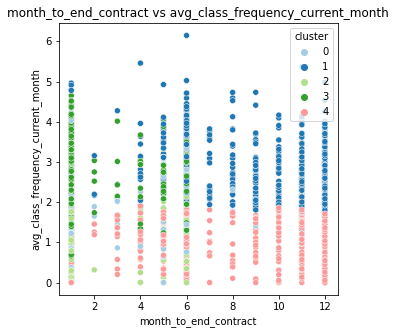

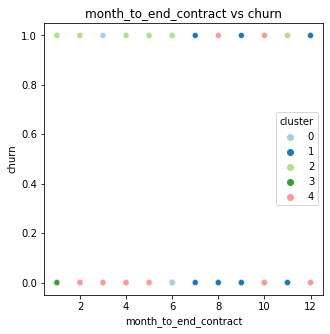

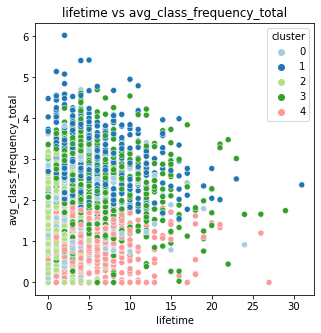

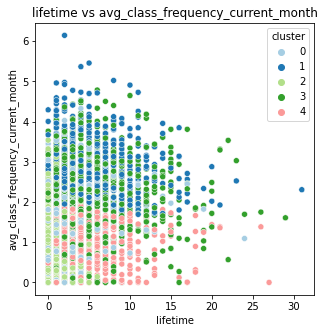

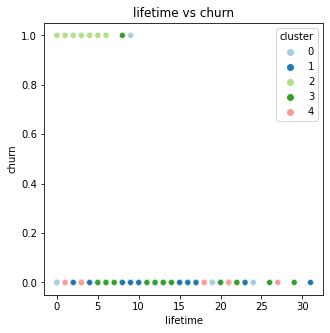

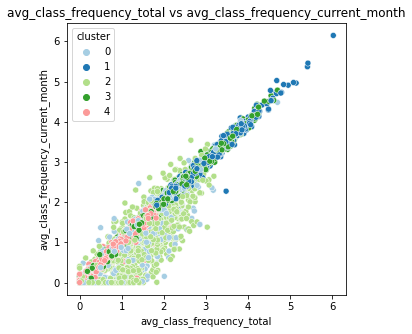

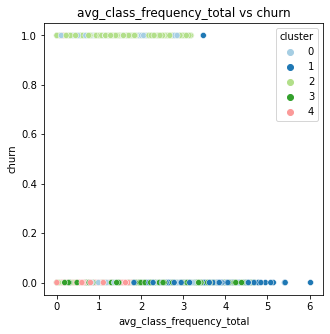

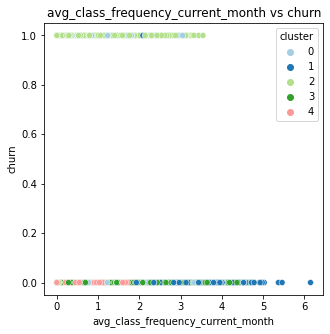

In [22]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(gym.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(gym, pair[0], pair[1], 'cluster')

In [23]:
# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.13


Метрика силуэта показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой. Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.

В нашем случае значение метрики получилось не слишком высоким, над качеством разделения на кластеры еще можно поработать.

**Основные выводы по разделению на кластеры:**
- соотношение полов и наличия номеров телефонов примерно одинаковое во всех кластерах
- клиенты всех кластеров кроме 0 проживают или работают рядом с клубом
- клиентов, которые пришли в клуб по партнерству работодателя, или по программе приведи друга, больше всего в 1 и 4 кластерах
- клиентов с длительным контрактом и с длительным сроком до окончания контракта - в 1 и 4 кластере, самый короткий контракт у клиентов 3 кластера
- клиенты, посещающие групповые занятия наиболее часто - 1, 4 и 3 кластер. У этих же клиентов максимальный срок жизни. Минимально посещают групповые классы - в 0 и 2 кластере, у них же и самый маленький lifetime (особенно у 2 группы)
- самые молодые клиенты находятся во 2 кластере, самые зрелые - в 3
- больше всего дополнительных расходов несут клиенты 1 и 4 кластера, а меньше всего - клиенты 2 кластера
- средняя частота посещения групповых классов в неделю выше всего у 1 и 4 группы, самая низкая - у 4. 
- в текущем месяце частота посещений групповых занятий снизилась у 0 и 2 группы

**Самый высокий отток наблюдается в кластерах 2 и 0. Их отличительные признаки:**
- кластер 0 живет далеко от клуба,
- меньше всего клиентов по партнерству с работодателем или по акции приведи друга
- абонемент короткий (1 месяц, максимум 3)
- самые молодые клиенты
- минимальная сумма дополнительных расходов
- низкий уровень посещения групповых классов
- уровень посещения снизился в текущем месяце

**Самый низкий уровень оттока в 1, 3, 4 кластерах:**
- живут/ работают рядом с клубом
- 1 и 4 пришли по скидке работодателя или друга
- 1 и 4 имеют длительный контракт (и длительный срок до его окончания)
- 45% и больше участников кластера посещают групповые занятия
- более "зрелый" возраст
- больше всего дополнительных расходоы (особенно 1 и 4 группы)
- все имеют длинный lifetime
- 1 и 3 чаще посещают групповые занятия (максимальная частота среди всех кластеров)
- 4 минимальная частота посещения групповых занятий, но стабильная на протяжении всех изучаемых периодов

**Я бы отметила основные отличия между кластерами так:**
- 0 кластер - живут далеко
- 1 кластер - длительный контракт + частое посещение групповых, скидки
- 2 кластер - молодые, активно посещают групповые, но тратят мало внутри. Без скидки Приведи друга или от работодателя
- 3 кластер - без скидки, зрелые, много тратят внутри, часто посещают групповые
- 4 кластер - длительный контракт + редкое посещение групповых, скидки

## Выводы и рекомендации

### Изучение исходных данных¶
Таблица состоит из 14 столбцов и 4000 строк с разными типами значений.
Пропусков данных и явных дубликатов не обнаружено.

### Предобработка данных
Переименовали ряд заголовков: сделаем написание строчными буквами
Других корректировок не потребовалось

### Исследовательский анализ данных (EDA)
#### Первичная оценка параметров данных
**gender:** количество клиентов с полом 1 составляет 51%, в целом, можно сказать, что деление 50 на 50.

**near_location:** количество клиентов,  у которых фитнес центр находится в районе проживания / работы составляет 84,5%.
    
**partner:** 48,7% клиентов пришли со скидкой от компании-партнера клуба.
    
**promo_friends:** 30% клиентов пришли по акции Приведи друга.  

**phone:** 90% клиентов указали номер телефона. 

**contract_period:** средняя длительность текущего абонемента у клиентов составляет 4.68 месяцев

**group_visits:** количество клиентов, которые посещают групповые занятия составляет 41,2%.
     
**age:** средний возраст клиентов фитнес-клуба - 29 лет,
     
**avg_additional_charges_total**: средняя суммарная выручка от других услуг фитнес-центра составялет 146.9 у.е.

    
**month_to_end_contract:**
- средний срок до оконачания текущего абонемента составляет 4.32 месяца, 
- медиана составляет - 1 месяц
В целом цифры совпадают с аналогичными по сроку контракта.
    
**lifetime:** средний "срок жизни" текущих клиентов составляет - 3.72 месяца,

**avg_class_frequency_total:** средняя частота посещений в неделю за весь срок действия абонемента составляет - 1.88 шт.,
    
**avg_class_frequency_current_month:** средняя частота посещений в неделю за текущий месяц составляет - 1.77 шт.,
    
**churn:** отток клиентов за текущий месяц составляет 26.5%.

#### Средние значения и распределение признаков в группе оставшихся клиентов и в группе ушедших
Те, кто остался:
* примерно одинаковые по соотношению полов, номеров телефонов с теми, кто ушел
* чаще живут/работают рядом со спортзалом
* чаще **работают в компании-партнере фитнесс-центра**
* чаще пришли **по программе Приведи друга**
* имеют **более длительный контракт** и более длительный срок до окончания контакта, а также более длинный lifetime
* чаще **посещают групповые занятия**
* более зрелые (но в среднем разница всего 3 года)
* чаще оплачивают дополнительные услуги
* чаще посещают групповые занятия (2 в неделю), те, кто уходят - меньше 1.5. 
**Посещение групповых занятий в текущем месяце у них такое же, как и в предущие**. При этом, у тех, кто уйдет, оно снизилось.

Диаграммы рассеяния и столбчатые диаграммы подтверждают выводы, сделанные по средним значениям:
- возраст - более "зрелые" клиенты более лояльны
- дополнительные расходы в клубе - использование дополнительных услуг фитнес-клуба снижает вероятность "ухода"
- срок "жизни" клиента в клубе - чем он больше, тем выше вероятность, что клиент продолжит ходить
- посещение групповых классов - если клиент их посещает и чем чаще он их посещает, тем меньше вероятность, что он уйдет в следующем месяце

**Особенно следует отметить, что снижение среднего числа посещений групповых занятий в неделю, является "спутником" ухода клиента.**

#### Матрица корреляций признаков

2 параметра с очень сильной корреляцией - contract_period и month_to_end_contract_period. 
После удаления одного из мультиколлинеарных столбцоы по матрице корреляций можно отметить, что уровень оттока положительно зависит от пола и отрицательно от других параметров. Особенно на уровень оттока влияет возраст клиента. Пол оказывает наименьшее влияние.

### Модель прогнозирования оттока клиентов
#### Создание и обучение моделей, расчет метрик и сравнение моделей

Прогнозирование оттока клиентов произведено 2 моделями: логистической регресией и случайным лесом.
По признаку Accuracy модель идентичны, но по признакам Precision и Recall, получается, что более точная модель Logistic Regression.
*LogisticRegression(random_state=0)
Accuracy: 0.92 Precision: 0.85 Recall: 0.83
RandomForestClassifier(random_state=0)
Accuracy: 0.92 Precision: 0.84 Recall: 0.81*
Соответственно, для дальнейшего прогнозирования рекомендуется использовать логистическую регрессию.

### Кластеризация клиентов
#### Кластеризация с использованием дендрограммы

C использованием дендрограммы мы можем выделить 5 разных классов клиентов. 

#### Кластеризация методом K-means

После кластеризации методом K-means с числом кластеров 5 основные отличия между кластерами выглядят так:
- 0 кластер - живут далеко, половина пришла по скидке работодателя, молодой возраст, лайфтайм средний
- 1 кластер - длительный контракт + частое посещение групповых, скидки
- 2 кластер - молодые, активно посещают групповые, но тратят мало внутри. Без скидки Приведи друга или от работодателя
- 3 кластер - без скидки, зрелые, много тратят внутри, часто посещают групповые
- 4 кластер - длительный контракт + редкое посещение групповых, скидки

### Предложения по удержанию клиентов различных кластеров

**0 кластер**<br>
Высокий уровень оттока<br>
Основная проблема - расстояние и отсутствие скидки у тех, кто пришел не от работодателя
Варианты решения:
- проанализировать местоположение работодателя и ближайшего транспортного узла, организовать транспорт от/до места работы/транспортного узла
- предложить нестандартные часы работы, чтобы клиенты успевали позаниматься до работы/учебы/других дел
- дополнительная скидка на следующий период
На мой взгляд, все варианты очень затратны и, возможно, нерентабельны.

**1 кластер**<br>
Низкий уровень оттока, проблем не наблюдается.<br>
Дополнительные меры, чтобы обеспечивать интерес этой группы:
- добавлять новые "модные" групповые занятия
- предложить нестандартную длительность групповой тренировки в дневное время в рабочие дни, например, 40-45 минут, чтобы клиенты успевали позаниматься в обеденный перерыв
- дополнительные скидки на покупку "длинных абонементов"

**2 кластер**<br>
Максимальный уровень оттока.<br>
Основные проблемы: отсутствие скидки, юный возраст, возможно, низкие доходы
Дополнительные меры, чтобы обеспечивать интерес этой группы:
- добавлять новые "модные" групповые занятия
- предлагать рассрочку на длительные абонементы
- расширить ассортимент дополнительных услуг, предложив "хайповые" среди молодежи (те, которых нет)
- геймификация: есть минимальная скидка на следующий абонемент, но ее можно увеличить за счет активного посещения групповых / покупки дополнительных услуг
- скидка за нестандартное время (дневные часы в будни)

**3 кластер**<br>
Низкий уровень оттока.<br>
Дополнительные меры, чтобы обеспечивать интерес этой группы:
- не похоже, что скидки для этой группы будут иметь значение, надо сосредотачиваться на качестве и количестве услуг
- добавлять новые "модные" групповые занятия
- расширять ассортимент дополнительных услуг

**4 кластер**<br>
Низкий уровень оттока.<br>
Дополнительные меры, чтобы обеспечивать интерес этой группы:
- тк у этой группы достачно редкое посещение групповых, надо обратить внимание на другие форматы тренировки (тренажерный зал, бассейн?). 
- дополнительные скидки на покупку "длинных абонементов"
- расширять ассортимент дополнительных услуг